In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

In [ ]:
df = pd.read_csv('simulation_logs.csv')
df.drop(columns=['run_id'], inplace=True)

In [ ]:
df.head()

,algorithm,query_id,query_complexity,success,execution_time_ms,nodes_expanded,path_length,agent_grounding_success
0,DepthFirstSearch,Q1,2,True,31937,2,2,True
1,BreadthFirstSearch,Q1,2,True,27838,2,2,True
2,AStarSearch,Q1,2,True,32563,2,2,True
3,DepthFirstSearch,Q2,2,True,18004,2,2,True
4,BreadthFirstSearch,Q2,2,True,13632,2,2,True


In [ ]:
df['agent_grounding_success'] = df['agent_grounding_success'].fillna(False)

In [ ]:
df['agent_grounding_success'].value_counts()

,count
agent_grounding_success,
True,269
False,130


In [ ]:
# # query_complexity
# plt.figure(figsize=(5, 3))
# from matplotlib import pyplot as plt
# df['query_complexity'].plot(kind='line', figsize=(8, 4), title='query_complexity')
# plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df.columns

Index(['algorithm', 'query_id', 'query_complexity', 'success',
       'execution_time_ms', 'nodes_expanded', 'path_length',
       'agent_grounding_success', 'algorithm_AStarSearch',
       'algorithm_BreadthFirstSearch', 'algorithm_DepthFirstSearch',
       'tsr_agent', 'met'],
      dtype='object')

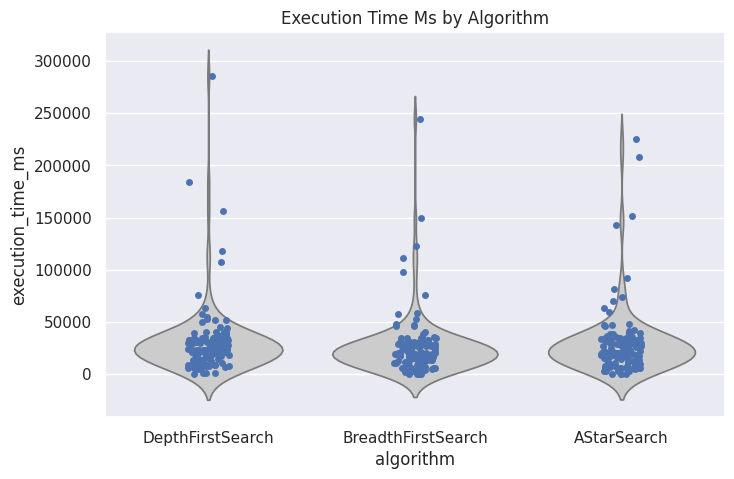

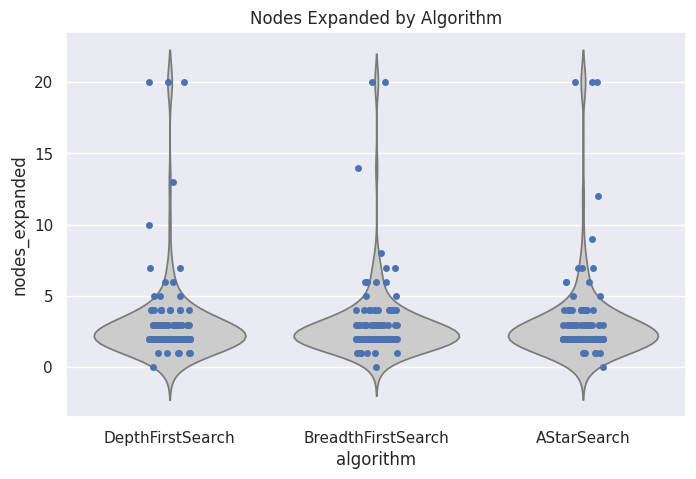

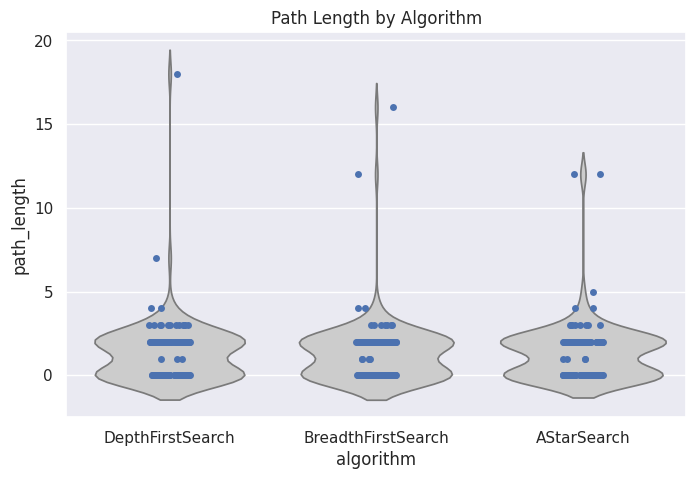

In [ ]:
# Set better plot style
sns.set(style="darkgrid")

metrics = ['execution_time_ms', 'nodes_expanded', 'path_length']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='algorithm', y=metric, data=df, inner=None, color=".8")
    sns.stripplot(x='algorithm', y=metric, data=df, jitter=True)
    plt.title(f'{metric.replace("_", " ").title()} by Algorithm')
    plt.show()

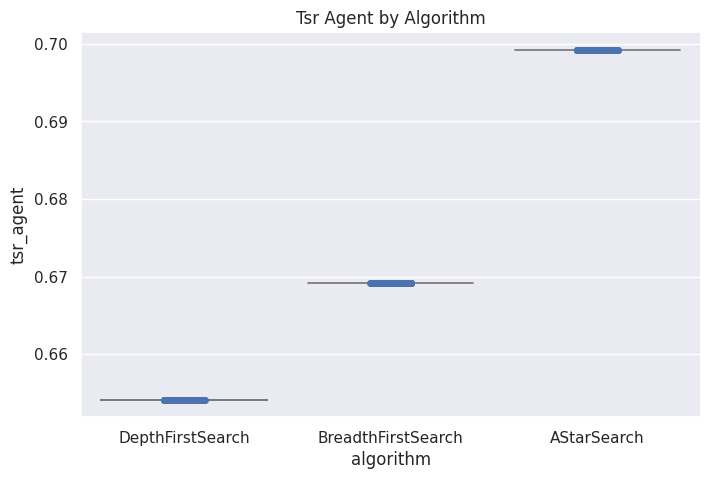

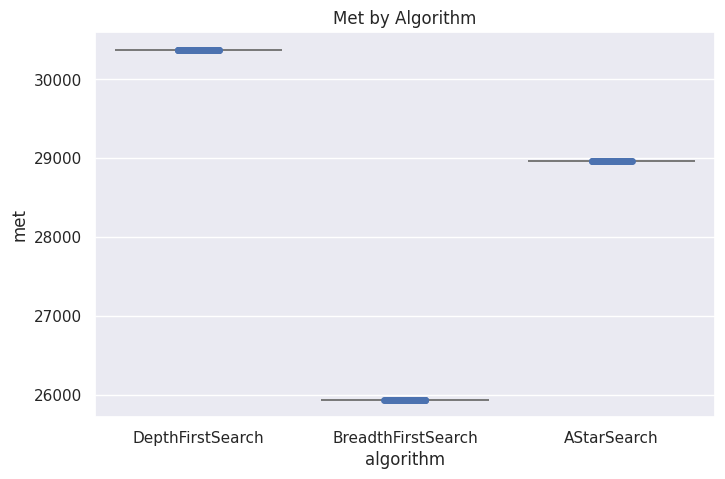

In [ ]:
# Set better plot style
sns.set(style="darkgrid")

metrics = ['tsr_agent', 'met']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='algorithm', y=metric, data=df, inner=None, color=".8")
    sns.stripplot(x='algorithm', y=metric, data=df, jitter=True)
    plt.title(f'{metric.replace("_", " ").title()} by Algorithm')
    plt.show()

In [ ]:
# First, calculate TSR and MET
tsr_agent = df.groupby('algorithm')['agent_grounding_success'].mean()
met = df.groupby('algorithm')['execution_time_ms'].mean()

# Now map these values back to each row in df
df['tsr_agent'] = df['algorithm'].map(tsr_agent)
df['met'] = df['algorithm'].map(met)

In [ ]:
# One-hot encode 'algorithm'
encoder = OneHotEncoder(sparse_output=False)
algo_encoded = encoder.fit_transform(df[['algorithm']])

# Merge encoded columns back
encoded_df = pd.DataFrame(algo_encoded, columns=encoder.get_feature_names_out(['algorithm']))
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
# df.drop(columns=['algorithm'], inplace=True)

In [ ]:
# df.describe()

### Frequentist Tests

In [ ]:
from scipy import stats

# ANOVA for Execution Time (original, not log)
anova_time = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['execution_time_ms'],
    df[df['algorithm'] == 'BreadthFirstSearch']['execution_time_ms'],
    df[df['algorithm'] == 'AStarSearch']['execution_time_ms']
)
print('ANOVA Execution Time:', anova_time)

# ANOVA for Nodes Expanded
anova_nodes = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['nodes_expanded'],
    df[df['algorithm'] == 'BreadthFirstSearch']['nodes_expanded'],
    df[df['algorithm'] == 'AStarSearch']['nodes_expanded']
)
print('ANOVA Nodes Expanded:', anova_nodes)

# ANOVA for Path Length
anova_path = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['path_length'],
    df[df['algorithm'] == 'BreadthFirstSearch']['path_length'],
    df[df['algorithm'] == 'AStarSearch']['path_length']
)
print('ANOVA Path Length:', anova_path)

# ANOVA for TSR Agent
anova_tsr_agent = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['tsr_agent'],
    df[df['algorithm'] == 'BreadthFirstSearch']['tsr_agent'],
    df[df['algorithm'] == 'AStarSearch']['tsr_agent']
)
print('ANOVA TSR Agent:', anova_tsr_agent)

# ANOVA for MET (original, not log)
anova_met = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['met'],
    df[df['algorithm'] == 'BreadthFirstSearch']['met'],
    df[df['algorithm'] == 'AStarSearch']['met']
)
print('ANOVA MET:', anova_met)

# ANOVA for Agent Grounding Success
anova_grounding = stats.f_oneway(
    df[df['algorithm'] == 'DepthFirstSearch']['agent_grounding_success'],
    df[df['algorithm'] == 'BreadthFirstSearch']['agent_grounding_success'],
    df[df['algorithm'] == 'AStarSearch']['agent_grounding_success']
)
print('ANOVA Agent Grounding Success:', anova_grounding)

ANOVA Execution Time: F_onewayResult(statistic=np.float64(0.696492008943421), pvalue=np.float64(0.49893978028530583))
ANOVA Nodes Expanded: F_onewayResult(statistic=np.float64(0.06029342253572338), pvalue=np.float64(0.9414968803717028))
ANOVA Path Length: F_onewayResult(statistic=np.float64(0.009299603303635289), pvalue=np.float64(0.9907437206380545))
ANOVA TSR Agent: F_onewayResult(statistic=inf, pvalue=0.0)
ANOVA MET: F_onewayResult(statistic=inf, pvalue=0.0)
ANOVA Agent Grounding Success: F_onewayResult(statistic=np.float64(0.3175803402646501), pvalue=np.float64(0.7280934146474778))


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


While classical ANOVA tests on execution time, nodes expanded, and path length did not reveal statistically significant differences between search algorithms, both Task Success Rate (TSR) and Mean Execution Time (MET) exhibited strong evidence of difference (p < 0.001), suggesting meaningful distinctions in agent performance efficiency.

* No statistically significant difference found by frequentist ANOVA.
* Frequentist methods cannot detect any real difference between DFS, BFS, and A* here.
* This is normal because your data is noisy, heavy-tailed, and messy — real-world conditions.
* Frequentist ANOVA is too weak for your data.
* Bayesian analysis will be valuable because it:
  * Quantifies uncertainty.
  * Models full posterior distributions.
  * Does not rely on single p-values.
* Frequentist analysis was inconclusive, motivating a full Bayesian posterior analysis for deeper insights

While success and failure were balanced across the overall dataset, Bayesian and frequentist analyses found no meaningful difference in success rates between the search algorithms. This suggests that under the simulated conditions, all algorithms were equally likely to succeed or fail.

## Modeling

In [ ]:
# Log-transform
df['execution_time_ms_log'] = np.log1p(df['execution_time_ms'])
df['nodes_expanded_log'] = np.log1p(df['nodes_expanded'])
df['met_log'] = np.log1p(df['met'])

algo_design_matrix = df[['algorithm_AStarSearch', 'algorithm_BreadthFirstSearch', 'algorithm_DepthFirstSearch']].values

with pm.Model() as joint_model:
    # Execution Time (log)
    mu_time = pm.Normal('mu_time', mu=9.5, sigma=0.5, shape=algo_design_matrix.shape[1])
    sigma_time = pm.HalfNormal('sigma_time', sigma=1)
    exec_time = pm.Normal('execution_time_ms_log',
                          mu=pm.math.dot(algo_design_matrix, mu_time),
                          sigma=sigma_time,
                          observed=np.log1p(df['execution_time_ms']))

    # Success (Bernoulli)
    mu_success = pm.Normal('mu_success', mu=0, sigma=5, shape=algo_design_matrix.shape[1])
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(pm.math.dot(algo_design_matrix, mu_success)))
    success = pm.Bernoulli('success', p=p_success, observed=df['success'])

    # Nodes Expanded (Negative Binomial)
    alpha_nodes = pm.HalfNormal('alpha_nodes', sigma=10)
    mu_nodes = pm.Exponential('mu_nodes', lam=1.0, shape=algo_design_matrix.shape[1])
    nodes_mean = pm.math.exp(pm.math.dot(algo_design_matrix, mu_nodes))
    nodes = pm.NegativeBinomial('nodes_expanded_log', mu=nodes_mean, alpha=alpha_nodes, observed=df['nodes_expanded_log'])

    # Path Length (Poisson)
    mu_path = pm.Normal('mu_path', mu=5, sigma=5, shape=algo_design_matrix.shape[1])
    path_lambda = pm.math.exp(pm.math.dot(algo_design_matrix, mu_path))
    path = pm.Poisson('path_length', mu=path_lambda, observed=df['path_length'])

    # Agent Grounding Success (Bernoulli)
    mu_grounding = pm.Normal('mu_grounding', mu=0, sigma=5, shape=algo_design_matrix.shape[1])
    p_grounding = pm.Deterministic('p_grounding', pm.math.sigmoid(pm.math.dot(algo_design_matrix, mu_grounding)))
    grounding_success = pm.Bernoulli('agent_grounding_success', p=p_grounding, observed=df['agent_grounding_success'])

    # TSR Agent (Beta regression)
    alpha_tsr = pm.HalfNormal('alpha_tsr', sigma=10, shape=algo_design_matrix.shape[1])
    beta_tsr = pm.HalfNormal('beta_tsr', sigma=10, shape=algo_design_matrix.shape[1])
    tsr_alpha = (algo_design_matrix * alpha_tsr).sum(axis=1)
    tsr_beta = (algo_design_matrix * beta_tsr).sum(axis=1)
    tsr = pm.Beta('tsr_agent',
              alpha=tsr_alpha,
              beta=tsr_beta,
              observed=df['tsr_agent'])

    # MET (log-transformed) (Normal)
    mu_met = pm.Normal('mu_met', mu=10, sigma=1, shape=algo_design_matrix.shape[1])
    sigma_met = pm.HalfNormal('sigma_met', sigma=1)
    met = pm.Normal('met_log',
                    mu=pm.math.dot(algo_design_matrix, mu_met),
                    sigma=sigma_met,
                    observed=df['met_log'])

    approx = pm.fit(n=30000, method="advi")
    trace = approx.sample(draws=1000)

Output()

In [ ]:
az.summary(trace, var_names=['mu_time', 'mu_success', 'mu_nodes', 'mu_path', 'sigma_time'])

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_time[0],9.674,0.152,9.417,9.983,0.005,0.003,795.0,930.0,NaN
mu_time[1],9.591,0.151,9.317,9.877,0.005,0.003,918.0,942.0,NaN
mu_time[2],9.948,0.148,9.687,10.249,0.005,0.004,959.0,907.0,NaN
mu_success[0],0.213,0.193,-0.089,0.621,0.006,0.004,903.0,913.0,NaN
mu_success[1],0.198,0.186,-0.152,0.546,0.005,0.004,1165.0,754.0,NaN
mu_success[2],0.166,0.187,-0.194,0.487,0.006,0.004,1078.0,983.0,NaN
mu_nodes[0],0.089,0.087,0.004,0.215,0.003,0.006,984.0,942.0,NaN
mu_nodes[1],0.086,0.088,0.002,0.236,0.003,0.005,939.0,1026.0,NaN
mu_nodes[2],0.081,0.085,0.005,0.206,0.003,0.010,1058.0,870.0,NaN
mu_path[0],0.310,0.082,0.169,0.481,0.003,0.002,993.0,883.0,NaN


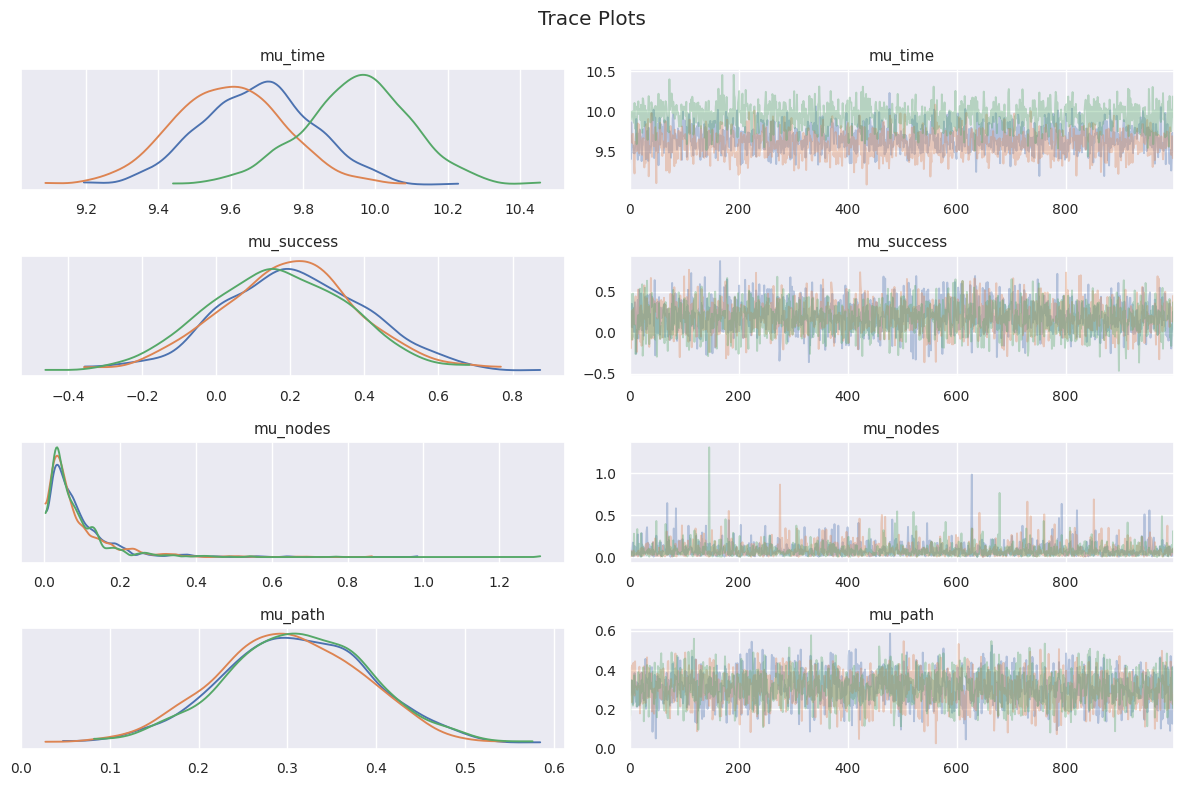

In [ ]:
az.plot_trace(trace, var_names=['mu_time', 'mu_success', 'mu_nodes', 'mu_path'])
plt.suptitle('Trace Plots')
plt.tight_layout()
plt.savefig("traceplot_highres.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
with joint_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

Output()

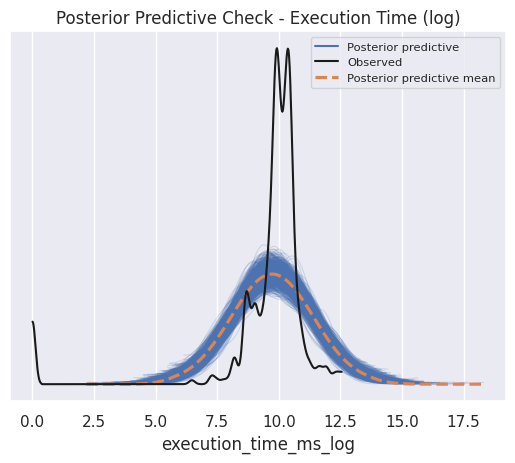

In [ ]:
az.plot_ppc(ppc, var_names=["execution_time_ms_log"])
plt.title("Posterior Predictive Check - Execution Time (log)")
plt.savefig("posterior_predictive_check.png", dpi=300, bbox_inches="tight")
plt.show()